In [2]:
# 引入必要函式庫
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 讀取資料
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Testset.csv')

# 提取測試集的 ID 欄位
test_ids = test_df['ID']

# 處理類別型欄位
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1', 'Spending_Score']
label_encoders = {}

for col in categorical_cols:
    encoder = LabelEncoder()
    train_df[col] = encoder.fit_transform(train_df[col].astype(str))
    test_df[col] = encoder.transform(test_df[col].astype(str))
    label_encoders[col] = encoder

# 檢查是否有未處理的類別型欄位
for col in train_df.select_dtypes(include=['object']).columns:
    if col not in categorical_cols:
        print(f"未處理的類別型欄位: {col}")

# 分離目標變量與特徵
y = train_df['Segmentation']
X = train_df.drop(columns=['ID', 'Segmentation'])
test_features = test_df.drop(columns=['ID'])

# 標準化數值特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_features)

# 分割訓練集與驗證集
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 設定 RandomForest 模型
rf_model = RandomForestClassifier(random_state=42)

# 使用 GridSearchCV 調參
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 使用最佳參數重新訓練模型
best_rf_model = grid_search.best_estimator_

# 評估模型
y_val_pred = best_rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# 測試集預測
test_predictions = best_rf_model.predict(test_scaled)

# 生成提交檔案
output_df = pd.DataFrame({'ID': test_ids, 'Segmentation': test_predictions})
output_df.to_csv('submission.csv', index=False)
print("Test predictions saved to 'submission.csv'.")


未處理的類別型欄位: Segmentation
Fitting 2 folds for each of 81 candidates, totalling 162 fits
Validation Accuracy: 0.5285
Classification Report:
               precision    recall  f1-score   support

           A       0.46      0.46      0.46       487
           B       0.41      0.33      0.37       457
           C       0.57      0.57      0.57       508
           D       0.62      0.71      0.66       548

    accuracy                           0.53      2000
   macro avg       0.51      0.52      0.52      2000
weighted avg       0.52      0.53      0.52      2000

Test predictions saved to 'submission.csv'.


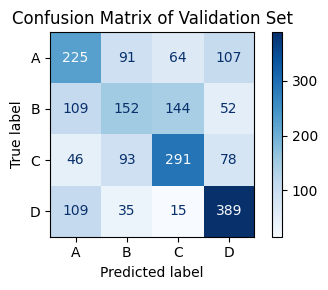

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_val_pred, labels=['A', 'B', 'C', 'D'])

# 視覺化混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C', 'D'])
fig, ax = plt.subplots(figsize=(4, 3))  # 調整圖片大小
disp.plot(ax=ax, cmap='Blues', values_format='d')  # 'd' 表示整數格式

# 儲存圖片
plt.title('Confusion Matrix of Validation Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

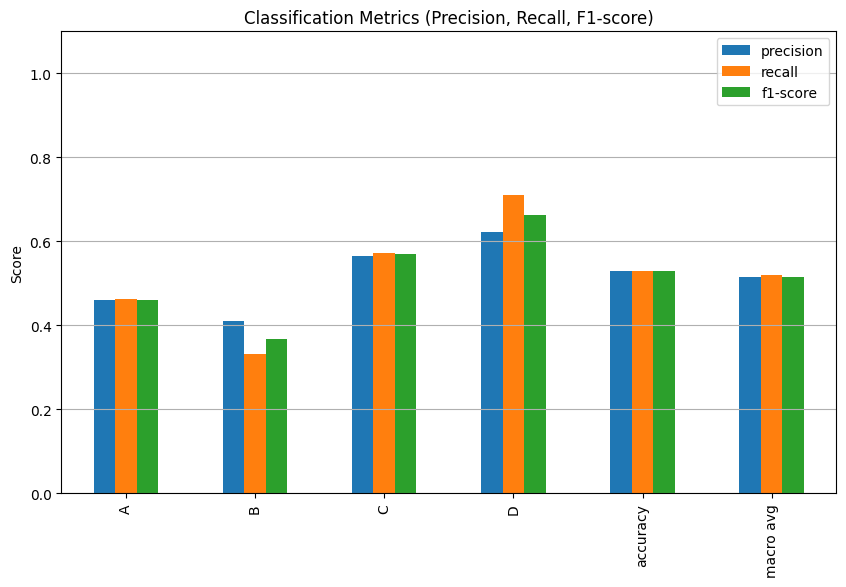

In [3]:
# 精確率 (Precision)、召回率 (Recall)、F1 分數
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

report = classification_report(y_val, y_val_pred, output_dict=True)
scores_df = pd.DataFrame(report).transpose()

scores_df.iloc[:-1, :3].plot(kind='bar', figsize=(10, 6))
plt.title("Classification Metrics (Precision, Recall, F1-score)")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(True, axis='y')
plt.show()
